# Assignment 3: Object Detection and Recognition

## 1. Description of the dataset

We use the **Penn-Fudan Database for Pedestrian Detection and Segmentation**.
It contains 170 images with 345 instances of pedestrians.

Link: [Penn-Fudan Database](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip) (similar to the Kaggle link provided)

---

## 2. Theoretical Background

### 2.1 Principles of Convolutional Neural Networks (CNNs)
Convolutional Neural Networks (CNNs) are a class of deep neural networks, most commonly applied to analyzing visual imagery. They shift across the image with a kernel (filter) to detect features such as edges, textures, and eventually complex shapes.

**Key Layers:**
*   **Convolutional Layer:** Applies filters to the input to create feature maps.
*   **Pooling Layer (Subsampling):** Reduces dimensionality (e.g., Max Pooling) to reduce computation and control overfitting.
*   **Fully Connected Layer:** Connects every neuron in one layer to every neuron in another layer, typically used at the end for classification.

### 2.2 Validation and Cross-Validation

**Validation:**
Validation is the process of evaluating a trained model on a separate subset of data that was not used during training. Its goal is to assess how well the model generalizes and to prevent overfitting.

**Cross-Validation:**
Cross-validation is a statistical method where the dataset is divided into $k$ parts (folds). The model is trained on $k-1$ folds and tested on the remaining one, repeating the process $k$ times. This provides a more convenient and unbiased estimate of model performance.

### 2.3 Overview of 8 Neural Network Architectures

| № | Architecture | Type | Key Features | Application |
|---|---|---|---|---|
| 1 | **LeNet-5** | CNN | Basic early CNN with few layers | Simple image classification (digits) |
| 2 | **AlexNet** | CNN | Deep network using ReLU and Dropout | Image classification |
| 3 | **VGG16/19** | CNN | Uniform 3x3 filters, deep architecture | High accuracy, high cost |
| 4 | **GoogLeNet** | CNN | Inception modules (parallel convs) | Balanced accuracy/efficiency |
| 5 | **ResNet50/101** | CNN | Residual (skip) connections | Very deep networks without gradient vanishing |
| 6 | **MobileNetV2** | CNN | Inverted residuals, linear bottlenecks | Mobile/Real-time devices |
| 7 | **YOLOv5** | Object Detection | Single-shot, anchor-based | Fast real-time detection |
| 8 | **Faster R-CNN** | Object Detection | Two-stage (RPN + Classifier) | High accuracy detection |

---

## 3. Implementation

### 3.1 Environment and Dataset


In [7]:
import os
import torch
import torchvision
from torchvision.transforms import functional as F
from torchvision.io import read_image
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

# Ensure reproducible results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Torch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Using device: cuda


In [8]:
# Download dataset
import requests
import zipfile

DATA_URL = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
DATA_DIR = 'data'
ZIP_FILE = os.path.join(DATA_DIR, 'PennFudanPed.zip')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(ZIP_FILE) and not os.path.exists(os.path.join(DATA_DIR, 'PennFudanPed')):
    print("Downloading dataset...")
    r = requests.get(DATA_URL)
    with open(ZIP_FILE, 'wb') as f:
        f.write(r.content)
    print("Unzipping...")
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Done!")
else:
    print("Dataset already exists.")

Dataset already exists.


In [9]:
# Dataset Helper Class
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # IMPORTANT: Convert to tensor here to avoid AttributeError
        img = F.to_tensor(img)

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = cv2.imread(mask_path, 0)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
             # If user supplied extra transforms
             pass

        return img, target

    def __len__(self):
        return len(self.imgs)

## 4. Model Implementation

### 4.1 Model 1: Faster R-CNN with ResNet50
We use a pre-trained Faster R-CNN model and fine-tune it on our dataset.

In [10]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load a model pre-trained on COCO
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 2 classes: background + pedestrian
model = get_model_instance_segmentation(2)
model.to(device)
print("Faster R-CNN model loaded.")

Faster R-CNN model loaded.


Starting Faster R-CNN Training...
Epoch: 0, Iter: 0, Loss: 0.8128
Epoch: 0, Iter: 10, Loss: 0.5824
Epoch: 0, Iter: 20, Loss: 0.0826
Epoch: 0, Iter: 30, Loss: 0.0615
Epoch: 0, Iter: 40, Loss: 0.2351
Epoch: 0, Iter: 50, Loss: 0.1251
Epoch 0 finished. Avg Loss: 0.2550
Epoch: 1, Iter: 0, Loss: 0.1252
Epoch: 1, Iter: 10, Loss: 0.0553
Epoch: 1, Iter: 20, Loss: 0.0774
Epoch: 1, Iter: 30, Loss: 0.0915
Epoch: 1, Iter: 40, Loss: 0.0756
Epoch: 1, Iter: 50, Loss: 0.0496
Epoch 1 finished. Avg Loss: 0.1108
Epoch: 2, Iter: 0, Loss: 0.1822
Epoch: 2, Iter: 10, Loss: 0.0331
Epoch: 2, Iter: 20, Loss: 0.1781
Epoch: 2, Iter: 30, Loss: 0.0689
Epoch: 2, Iter: 40, Loss: 0.0581
Epoch: 2, Iter: 50, Loss: 0.1917
Epoch 2 finished. Avg Loss: 0.0955
Training Finished.


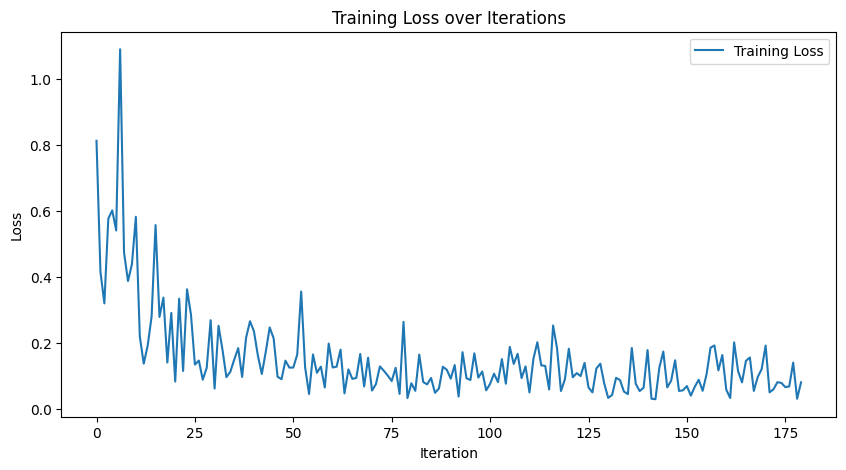

In [11]:
# Training Loop
from torch.utils.data import DataLoader, Subset

# Prepare Dataset
dataset = PennFudanDataset('data/PennFudanPed')

# Split indices
indices = torch.randperm(len(dataset)).tolist()
dataset_train = Subset(dataset, indices[:-50])
dataset_test = Subset(dataset, indices[-50:])

def collate_fn(batch):
    return tuple(zip(*batch))

# NOTE: num_workers=0 is important here to avoid multiprocessing errors in notebook cells
data_loader_train = DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn
)

data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn
)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 3
print("Starting Faster R-CNN Training...")

loss_history = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (images, targets) in enumerate(data_loader_train):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        loss_val = losses.item()
        loss_history.append(loss_val)
        epoch_loss += loss_val
        
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Iter: {i}, Loss: {loss_val:.4f}")
            
    print(f"Epoch {epoch} finished. Avg Loss: {epoch_loss/len(data_loader_train):.4f}")
    lr_scheduler.step()
print("Training Finished.")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()

### 4.2 Visualization of Predictions


Image 1 Predictions: 2 boxes


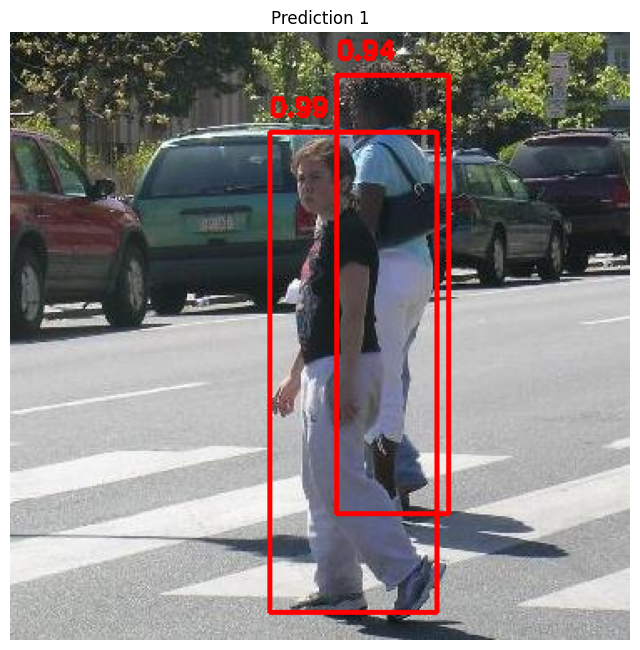

Image 2 Predictions: 7 boxes


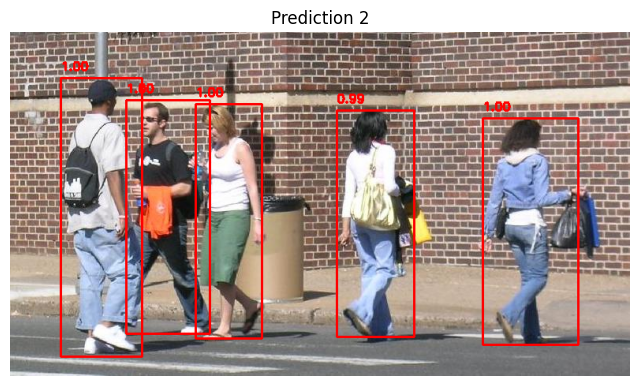

Image 3 Predictions: 4 boxes


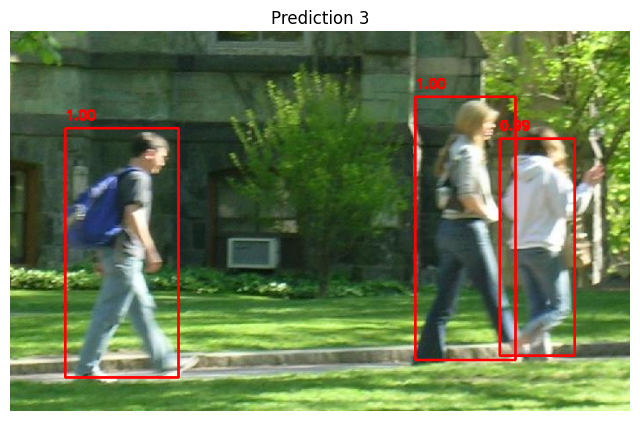

In [12]:
# Visualization Cell
model.eval()
images_to_show = 3

with torch.no_grad():
    for i, (img, target) in enumerate(data_loader_test):
        if i >= images_to_show: break
        
        # Move to device and get prediction
        img_tensor = img[0].to(device)
        prediction = model([img_tensor])
        
        # Move back to CPU for plotting
        # Convert tensor to numpy: (C, H, W) -> (H, W, C)
        img_np = img_tensor.mul(255).byte().cpu().numpy().transpose((1, 2, 0)).copy()
        
        # Draw boxes
        print(f"Image {i+1} Predictions: {len(prediction[0]['boxes'])} boxes")
        for box, score in zip(prediction[0]['boxes'], prediction[0]['scores']):
            if score > 0.5: # Confidence threshold
                x1, y1, x2, y2 = box.cpu().numpy().astype(int)
                cv2.rectangle(img_np, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img_np, f"{score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img_np)
        plt.title(f"Prediction {i+1}")
        plt.axis('off')
        plt.show()

### 4.3 Model 2: YOLOv5


In [13]:
from ultralytics import YOLO

# Load a model
# yolo_model = YOLO('yolov5su.pt')
# results = yolo_model.train(data='data/yolo_data/dataset.yaml', epochs=3, imgsz=640)
print("Ensure data/yolo_data/dataset.yaml exists before running YOLO training.")

Ensure data/yolo_data/dataset.yaml exists before running YOLO training.
